Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [8]:
from IPython.display import Image
Image(filename='notMNIST_small/A/SWFkZWxvbi1EZW1pQm9sZC5vdGY=.png') 

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
Pickling notMNIST_large\J.pickle.
notMNIST_large\J
Could not read: notMNIST_large\J\c3RhbmRhcmQgMDdfNTMudHRm.png : cannot identify image file 'notMNIST_large\\J\\c3RhbmRhcmQgMDdfNTMudHRm.png' - it's ok, skipping.
Full dataset tensor: (52910, 28, 28)
Mean: -0.153357
Standard deviation: 0.443656
Pickling notMNIST_small\A.pickle.
notMNIST_small\A
Could not read: notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

(52911, 28, 28)


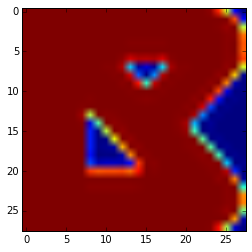

In [8]:
data_b = pickle.load(open( './notMNIST_large/B.pickle', "rb" ))

print(data_b.shape)
plt.imshow(data_b[1023])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 150000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (150000, 28, 28) (150000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

3


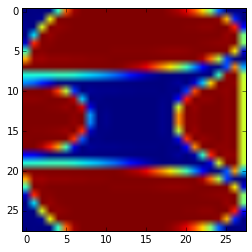

In [11]:

idx = np.random.randint(0,10000)
plt.imshow(train_dataset[idx])
print(train_labels[idx])


Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 533800503


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [2]:

def dist_img(x1,x2):
    return np.sqrt(np.sum(np.sum(np.subtract(x2,x1)**2,axis=2),axis=1))

#check if duplicates exist between dataset_1 and dataset_2 and sanitize dataset_2 according to 
def delete_dups_eff(dataset_1,dataset_1_y,threshold):
    
    test_hash = False

    partitions = (4,4)
    part_size = (dataset_1.shape[1]/partitions[0],dataset_1.shape[2]/partitions[1])
    
    #check withing train set
    hashcodes = {}
    bucket_size = 5 #group the each element of hashcode to a bucket
    
    for x_i in range(dataset_1.shape[0]):
        hash_key = ''
        
        for i in range(partitions[0]):
            for j in range(partitions[1]):
                if i==0 or i==partitions[0]-1 or j==0 or j==partitions[1]-1:
                    continue
                #print("Partition %i,%i"%(i,j))              
                #print("Sum for region: x(%i,%i) y(%i,%i)"%(i*part_size[0],(i+1)*part_size[0],j*part_size[1],(j+1)*part_size[1]))                
               
                sum_ij = np.sum(
                    np.sum(dataset_1[x_i][i*part_size[0]:(i+1)*part_size[0],j*part_size[1]:(j+1)*part_size[1]],axis=1),
                    axis=0)
                #print("\tSum: %f"%sum_ij)
                hash_key += str(int(sum_ij)-int(sum_ij)%bucket_size)+','
                
        if hash_key in hashcodes:
            hashcodes[hash_key].append(x_i)
        else:
            hashcodes[hash_key]=[x_i]
        
        if test_hash and x_i>50000:
            break
    
    san_train_y = np.empty(dataset_1_y.shape)
    san_train_set = np.empty(dataset_1.shape)
    t_i = 0
    test_sim = False
    for k,values in hashcodes.items():
        # if only one element for the key, no check. just add it
        if len(values)==1:            
            san_train_set[t_i]=dataset_1[values[0]]
            san_train_y[t_i]=dataset_1_y[values[0]]
            t_i += 1
            #print("Adding %i element (single)"%t_i)
            
        #if multiple elements exist, we need to perform distance calculation within the bucket
        else:      
            key_sim_indices = set() #will hold the set of indices of duplicate images
            len_values = len(values) #length of all indices in the bucket
            copy_values = [v for v in values] #copy for visualization purposes
            copy_dist_vec = None #copy for visualization purposes
            
            #continue this loop until only one element remain in the list
            while len(values)>1:
                # multiple elements for hashkey, check distance for each element
                # get the images belonging to the key except 0th element
                imgs_v = dataset_1[np.r_[values[1:]]]
                #calculate distance between element 0 and all others
                dist_vec = dist_img(dataset_1[values[0]],imgs_v)
                
                #for visualization ...
                if copy_dist_vec is None:
                    copy_dist_vec = [d for d in dist_vec]
                
                #get indices that are duplicates of 0th element
                sim_indices = np.where(dist_vec<threshold)[0]
                
                # add those to the key_sim_indices
                for sim_i in sim_indices:
                    key_sim_indices.add(values[sim_i+1])
                
                #delete the 0th element
                del values[0]
            
            # add all elements not in the key_sim_indices
            for v in copy_values:
                if v not in key_sim_indices:
                    san_train_set[t_i]=dataset_1[v]
                    san_train_y[t_i]=dataset_1_y[v]
                    t_i += 1
                    #print("Adding %i element (multiple)"%t_i)
            
            # this is for testing if the algo is acually finding similar iterms and not different ones
            if test_sim and len_values>5 and len_values<10:

                if np.random.random()<0.8:
                    continue
                fig,ax = plt.subplots(1,len_values)
                ax[0].imshow(dataset_1[copy_values[0]])
                for temp_i in range(len_values-1):
                    ax[temp_i+1].imshow(dataset_1[copy_values[temp_i+1]])
                print("Image indices: ",copy_values)
                print("Distances: ",copy_dist_vec)
                print("Similar indices: ",key_sim_indices)
                break
                
    san_train_set = np.delete(san_train_set,np.r_[t_i: dataset_1.shape[0]],axis=0)
    san_train_y = np.delete(san_train_y,np.r_[t_i: dataset_1_y.shape[0]],axis=0)
    
    print(san_train_set.shape)
    return (san_train_set,san_train_y)
       


This method is to calculate the duplicates between different datasets. It uses a hashing functions to speed up the calculations


In [3]:
def dist_img_3d(x1,x2):
    return np.sqrt(np.sum(np.sum(np.subtract(x2,x1)**2,axis=2),axis=1))

def dist_img_2d(x1,x2):
    return np.sqrt(np.sum(np.sum(np.subtract(x2,x1)**2)))

#check if duplicates exist between dataset_1 and dataset_2 and sanitize dataset_2 according to 
def delete_inter_dups_eff(dataset_1,dataset_1_y, dataset_2, dataset_2_y, threshold):
    
    test_hash = False

    partitions = (4,4)
    part_size = (dataset_1.shape[1]/partitions[0],dataset_1.shape[2]/partitions[1])
    
    #check withing train set
    hashcodes_d1,hashcodes_d2 = {},{}
    bucket_size = 5 #group the each element of hashcode to a bucket
    
    for x_i in range(dataset_1.shape[0]):
        hash_key = ''
        
        for i in range(partitions[0]):
            for j in range(partitions[1]):
                if i==0 or i==partitions[0]-1 or j==0 or j==partitions[1]-1:
                    continue
                #print("Partition %i,%i"%(i,j))              
                #print("Sum for region: x(%i,%i) y(%i,%i)"%(i*part_size[0],(i+1)*part_size[0],j*part_size[1],(j+1)*part_size[1]))                
               
                sum_ij = np.sum(
                    np.sum(dataset_1[x_i][i*part_size[0]:(i+1)*part_size[0],j*part_size[1]:(j+1)*part_size[1]],axis=1),
                    axis=0)
                #print("\tSum: %f"%sum_ij)
                hash_key += str(int(sum_ij)-int(sum_ij)%bucket_size)+','
                
        if hash_key in hashcodes_d1:
            hashcodes_d1[hash_key].append(x_i)
        else:
            hashcodes_d1[hash_key]=[x_i]
        
        if test_hash and x_i>50000:
            break
            
    for x_i in range(dataset_2.shape[0]):
        hash_key = ''
        
        for i in range(partitions[0]):
            for j in range(partitions[1]):
                if i==0 or i==partitions[0]-1 or j==0 or j==partitions[1]-1:
                    continue
                #print("Partition %i,%i"%(i,j))              
                #print("Sum for region: x(%i,%i) y(%i,%i)"%(i*part_size[0],(i+1)*part_size[0],j*part_size[1],(j+1)*part_size[1]))                
               
                sum_ij = np.sum(
                    np.sum(dataset_1[x_i][i*part_size[0]:(i+1)*part_size[0],j*part_size[1]:(j+1)*part_size[1]],axis=1),
                    axis=0)
                #print("\tSum: %f"%sum_ij)
                hash_key += str(int(sum_ij)-int(sum_ij)%bucket_size)+','
                
        if hash_key in hashcodes_d2:
            hashcodes_d2[hash_key].append(x_i)
        else:
            hashcodes_d2[hash_key]=[x_i]
        
        if test_hash and x_i>50000:
            break
    
    san_dataset_2 = np.empty(dataset_2.shape)
    san_2_y = np.empty(dataset_2_y.shape)
    didx_2 = 0
    #perform match between hashcodes dictionaries
    for k2,v2 in hashcodes_d2.items():
        if k2 in hashcodes_d1:            
            for v2 in hashcodes_d2[k2]:
                dist_vec=[]
                for v1 in hashcodes_d1[k2]:
                    #measure distance
                    dist_vec.append(np.asscalar(dist_img_2d(dataset_1[v1],dataset_2[v2])))
                #if distance too high, add to the sanitized dataset
                if np.min(dist_vec)>threshold:
                    san_dataset_2[didx_2]=dataset_2[v2]
                    san_2_y[didx_2]=dataset_2_y[v2]
                    didx_2 += 1
                        
    san_dataset_2 = np.delete(san_dataset_2,np.r_[didx_2: dataset_2.shape[0]],axis=0)
    san_2_y = np.delete(san_2_y,np.r_[didx_2: dataset_2_y.shape[0]],axis=0)
    print(san_dataset_2.shape)
    return san_dataset_2,san_2_y
       

Required imports (optional)

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [6]:

data = pickle.load(open( './notMNIST.pickle', "rb" ))
data_inputs=[data['train_dataset'],data['valid_dataset'],data['test_dataset']]
data_labels=[data['train_labels'],data['valid_labels'],data['test_labels']]
san_filenames=['train_sanitized.pickle','valid_sanitized.pickle','test_sanitized.pickle']
print("Data loaded")
threshold = 8.0

if not os.path.exists(san_filenames[0]):
    print("Creating the sanitized training set")
    san_train_x,san_train_y = delete_dups_eff(data_inputs[0],data_labels[0],threshold)
    san_tr_data = {'train_dataset':san_train_x,'train_labels':san_train_y}
    
    f = open(san_filenames[0], 'wb')    
    pickle.dump(san_tr_data, f,, pickle.HIGHEST_PROTOCOL)
else:
    print("Sanitized train file exists... Skipping")

if not os.path.exists(san_filenames[1]):
    print("Creating the sanitized valid set...")
    san_valid_x,san_valid_y = delete_inter_dups_eff(data_inputs[0],data_labels[0],data_inputs[1],data_labels[1],threshold)
    san_v_data = {'valid_dataset':san_valid_x,'valid_labels':san_valid_y}
    f = open(san_filenames[1], 'wb')    
    pickle.dump(san_v_data, f,, pickle.HIGHEST_PROTOCOL)

else:
    print("Sanitized valid file exists ... Skipping")

if not os.path.exists(san_filenames[2]):
    print("Creating the sanitized test set...")
    san_test_x,san_test_y = delete_inter_dups_eff(data_inputs[0],data_labels[0],data_inputs[2],data_labels[2],threshold)
    san_test_data = {'test_dataset':san_test_x,'test_labels':san_test_y}
    
    f = open(san_filenames[2], 'wb')    
    pickle.dump(san_test_data, f, , pickle.HIGHEST_PROTOCOL)
    

else:
    print("Sanitized test file exists ... Skipping")

    
'''fig,(ax1,ax2,ax3) = plt.subplots(1,3)
for k,v in hashcodes.items():
    if np.random.random()<0.9:
        continue
    if len(v)>2:
        ax1.imshow(data_inputs[0][v[0]])
        ax2.imshow(data_inputs[0][v[1]])
        ax3.imshow(data_inputs[0][v[2]])
        break'''

ValueError: unsupported pickle protocol: 4

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [5]:
from sklearn import linear_model


data = pickle.load(open( './notMNIST.pickle', "rb" ))
train_x,valid_x,test_x=data['train_dataset'],data['valid_dataset'],data['test_dataset']
train_y,valid_y,test_y=data['train_labels'],data['valid_labels'],data['test_labels']

trainx_flat = np.reshape(train_x,(train_x.shape[0],train_x.shape[1]*train_x.shape[2]))
validx_flat = np.reshape(valid_x,(valid_x.shape[0],valid_x.shape[1]*valid_x.shape[2]))
testx_flat = np.reshape(test_x,(test_x.shape[0],test_x.shape[1]*test_x.shape[2]))

print("Loaded RAW data ...")
print("\tSize Train:",train_x.shape,train_y.shape)
print("\tSize Valid:",valid_x.shape,valid_y.shape)
print("\tSize Test:",test_x.shape,test_y.shape)


trainsan_data = pickle.load(open( './train_sanitized.pickle', "rb" ))
validsan_data = pickle.load(open( './valid_sanitized.pickle', "rb" ))
testsan_data = pickle.load(open( './test_sanitized.pickle', "rb" ))

trainsan_x,trainsan_y = trainsan_data['train_dataset'],trainsan_data['train_labels']
validsan_x,validsan_y = validsan_data['valid_dataset'],validsan_data['valid_labels']
testsan_x,testsan_y = testsan_data['test_dataset'],testsan_data['test_labels']

trainsanx_flat = np.reshape(trainsan_x,(trainsan_x.shape[0],trainsan_x.shape[1]*trainsan_x.shape[2]))
validsanx_flat = np.reshape(validsan_x,(validsan_x.shape[0],validsan_x.shape[1]*validsan_x.shape[2]))
testsanx_flat = np.reshape(testsan_x,(testsan_x.shape[0],testsan_x.shape[1]*testsan_x.shape[2]))

print("Loaded Sanitized data ...")
print('\tBefore flattening...')
print("\tSize Train:",trainsan_x.shape,trainsan_y.shape)
print("\tSize Valid:",validsan_x.shape,validsan_y.shape)
print("\tSize Test:",testsan_x.shape,testsan_y.shape)
print('\tAfter flattening...')
print("\tSize Train:",trainsanx_flat.shape,trainsan_y.shape)
print("\tSize Valid:",validsanx_flat.shape,validsan_y.shape)
print("\tSize Test:",testsanx_flat.shape,testsan_y.shape)


assert trainsan_x.shape[0]==trainsan_y.shape[0]
assert validsan_x.shape[0]==validsan_y.shape[0]
assert testsan_x.shape[0]==testsan_y.shape[0]
print("Assert complete. X,Y samples matched in each dataset ...")

dataset_sizes = [50]
for s in dataset_sizes:
    print("Creating a Logistic classifer...")
    logistic = linear_model.LogisticRegression()

    print("Training the logistic classifier (%i samples) (Sanitized)..."%s)
    logistic = logistic.fit(trainsanx_flat[:s], trainsan_y[:s])

    print("Accuracy on the valid set (Sanitized):%.2f"%logistic.score(validsanx_flat, validsan_y)*100)
    print("Accuracy on the test set (Sanitized):%.2f"%logistic.score(testsanx_flat, testsan_y)*100)
    
for s in dataset_sizes:
    print("Creating a Logistic classifer...")
    logistic = linear_model.LogisticRegression()

    print("Training the logistic classifier (%i samples) (Raw)..."%s)
    logistic = logistic.fit(trainx_flat[:s], train_y[:s])
    print("Accuracy on the valid set (Raw):%.2f"%logistic.score(validx_flat, valid_y)*100)
    print("Accuracy on the test set (Raw):%.2f"%logistic.score(testx_flat, test_y)*100)

Loaded RAW data ...
	Size Train: (150000, 28, 28) (150000,)
	Size Valid: (10000, 28, 28) (10000,)
	Size Test: (10000, 28, 28) (10000,)
Loaded Sanitized data ...
	Before flattening...
	Size Train: (61489, 28, 28) (61489,)
	Size Valid: (9480, 28, 28) (9480,)
	Size Test: (9433, 28, 28) (9433,)
	After flattening...
	Size Train: (61489, 784) (61489,)
	Size Valid: (9480, 784) (9480,)
	Size Test: (9433, 784) (9433,)
Assert complete. X,Y samples matched in each dataset ...
Creating a Logistic classifer...
Training the logistic classifier (Sanitized)...
Accuracy on the valid set (Sanitized):0.80
Accuracy on the test set (Sanitized):0.88
Creating a Logistic classifer...
Training the logistic classifier (Raw)...
Accuracy on the valid set (Raw):0.82
Accuracy on the test set (Raw):0.89



Loaded RAW data ...
	Size Train: (150000, 28, 28) (150000,)
	Size Valid: (10000, 28, 28) (10000,)
	Size Test: (10000, 28, 28) (10000,)
Loaded Sanitized data ...
	Before flattening...
	Size Train: (61489, 28, 28) (61489,)
	Size Valid: (9480, 28, 28) (9480,)
	Size Test: (9433, 28, 28) (9433,)
	After flattening...
	Size Train: (61489, 784) (61489,)
	Size Valid: (9480, 784) (9480,)
	Size Test: (9433, 784) (9433,)
Assert complete. X,Y samples matched in each dataset ...
Creating a Logistic classifer...
Training the logistic classifier (Sanitized)...
Accuracy on the valid set (Sanitized):0.80
Accuracy on the test set (Sanitized):0.88
Creating a Logistic classifer...
Training the logistic classifier (Raw)...
Accuracy on the valid set (Raw):0.82
Accuracy on the test set (Raw):0.89